In [1]:
import numpy as np
import numpy.random as rnd
import time


def extend( A ):

    A = np.hstack(
        (A, np.zeros( (A.shape[0],1) ))
    ); A = np.vstack(
        (A, np.array( (0.0,)*(A.shape[1]-1) + (1.0,), ndmin=2 ))
    )

    return A


def downdateEx( A ):

    p = A.shape[ 0 ]
    q = A.shape[ 1 ]
    r = min( p, q )

    D = A[ :, -1 ]; D = D.reshape( p, 1 )

    # retrieve a first SVD representation
    U, s, Vt = np.linalg.svd( A, full_matrices=False )

    Q1, R1 = np.linalg.qr( 
        np.dot(
            np.dot( U, U.T ) - np.identity( p ),
            D
        )
    )

    Q2, R2 = np.linalg.qr(
        np.dot(
            np.identity( q ) - np.dot( Vt.T, Vt ),
            np.vstack(
                (np.zeros( (q-D.shape[1], D.shape[1] ) ),
                np.identity( D.shape[1] ))
            )
        )
    )

    l = D.shape[ 1 ]

    Q1p = Q1[ :, :l ]
    Q2p = Q2[ :, :l ]

    R1p = R1[ :l, : ]
    R2p = R2[ :l, : ]


    K = np.dot(

        np.vstack((
            -np.dot( U.T, D ),
            R1p
        )),

        np.hstack((
            np.dot(
                np.hstack((
                    np.zeros(( l, q-l )),
                    np.identity( l )
                )),
                Vt.T
            ),
            np.transpose( R2p )
        ))

    )

    K = K + np.diag( np.append( s, 0 ) )

    Uk, sk, Vtk = np.linalg.svd( K, full_matrices=False )


    Ud = np.dot(
        np.hstack((
            U,
            Q1p
        )),
        Uk
    )

    sd = sk
    sd[ abs( sd ) < 1.0e-10 ] = 0

    Vd = np.dot(
        np.hstack((
            Vt.T, Q2p
        )),
        Vtk.T
    )

    Vd = Vd[ :q-l, : ]
    Vdt = np.transpose( Vd )

    
    nm = Ud.shape[ 0 ]
    nn = Vdt.shape[ 1 ]
    nr = min( nm, nn )

    Ud = Ud[ :, :nr ]
    sd = sd[ :nr ]
    Vdt = Vdt[ :nr, : ]
    
    
    return Ud, sd, Vdt



class iSVD( object ):

    def __init__( self, inU, ins, inVt, updateVt = False ):

        self.m, self.n = inU.shape[ 0 ], inVt.shape[ 1 ]
        self.U, self.iU, self.s, self.iVt, self.Vt = inU, None, ins, None, inVt

        self.iVpsinv = None
        self.updateVt = updateVt

        
        
    def update( self, data ):
        
        a = data.reshape( data.shape[0], )
                
        # m = {U^T} a / m = U'^T {U^T} a (if U' is defined)
        mv = np.dot( self.U.T, a )
        if not self.iU is None:
            mv = np.dot( self.iU.T, mv )
        
        
        # assuming the rank does not increase, verifying below
        rankIncreasingUpdate = False
        
        if self.n < self.m:
            
            # p = a - Um / p = a - U U'm (if U' is defined)
            if self.iU is None:
                p = a - np.dot( self.U, mv )
            else:
                p = a -  np.dot( self.U, np.dot( self.iU, mv ) )
            
            # Ra = \| p \|_{2}
            Ra = np.linalg.norm( p, ord = 2 )
            
            # verify if the column is from the same subspace
            epsilon = np.sqrt( np.finfo(np.float64).eps * self.m**2 * self.n * 10*2 )                        
            if ( np.abs( Ra ) > epsilon ):
                rankIncreasingUpdate = True
        
        
        if rankIncreasingUpdate == False:

            # construct svd-decomposition (update s directly)
            C, self.s, Dt = self.diagUpdate( self.s, mv, column=False )

            # U' = C / U' = U'C (if U' is defined)
            if self.iU is None:
                self.iU = C
            else:
                self.iU = np.dot( self.iU, C )

            # if it was specified that V^T should be updated
            if self.updateVt:
                                
                r = Dt.shape[ 1 ]
                W = Dt[ 0:r, : ]
                w = Dt[ r, : ]; w.shape = ( 1, w.shape[0] )
                
                # \|w\|^2 - squared norm
                wnrmsq = np.linalg.norm( w, ord=2 )**2
                # W^{+} = W^T + \frac{ w^T }{ 1-\|w\|^2 }\(wW^T\)
                Wpsinv = W.T + np.dot( (1/(1-wnrmsq))*w.T, np.dot( w, W.T ) )
                del r, wnrmsq

                # V'_{new} = V'_{old} W (note: using the transposes below which,
                # in turn, gives the following form: V'^T_{new} = W^T V'^T_{old}
                if not self.iVt is None:
                    self.iVt = np.dot( W.T, self.iVt )
                else:
                    self.iVt = W.T

                # (V'^{+})_{new} = W^{+} (V'^{+})_{old}
                if not self.iVpsinv is None:
                    self.iVpsinv = np.dot( Wpsinv, self.iVpsinv )
                else:
                    self.iVpsinv = Wpsinv

                # V_{new} = \begin{bmatrix} V_{old} \\ w(V'^{+})_{new} \end{bmatrix}
                self.Vt = np.hstack( (self.Vt, np.dot( self.iVpsinv.T, w.T) ) )

                del w, Wpsinv, W
        
        if rankIncreasingUpdate == True:
        
            # adding a trailing 0 (0 column and a 0 row via diag.)
            S = np.concatenate( ( self.s, (0.0,) ) )
            mv = np.concatenate( ( mv, (Ra,) ) )

            C, self.s, Dt = self.diagUpdate( S, mv, column=True)

            self.U = np.hstack( (self.U, p[ :, np.newaxis ] / Ra) )
        
            if self.iU is None:
                self.iU = C
            else:
                self.iU = extend( self.iU )
                self.iU = np.dot( self.iU, C )

                
            if self.updateVt:
                self.Vt = extend( self.Vt )
                if not self.iVt is None:
                    self.iVt = np.dot( Dt.T, extend(self.iVt) )
                else:
                    self.iVt = Dt.T

                if not self.iVpsinv is None:
                    self.iVpsinv = np.dot( Dt.T, extend( self.iVpsinv ) )
                else:
                    self.iVpsinv = Dt.T
        
        self.n = self.Vt.shape[ 1 ]



    def downdate( self, k ):
        
        Ux, sx, Vtx = self.svd()
        A = np.dot( Ux, np.dot( np.diag(sx), Vtx ) )
        
        Af = A.copy()
        Af[ :, :Af.shape[1]-1 ] = A[ :, 1: ]
        
        self.U, self.s, self.Vt = downdateEx( Af )        

        self.iVpsinv = None
        
        self.iU = None
        self.iVt = None
        
        self.iVpsinv = None        
        self.n = self.Vt.shape[ 1 ]        
        
        

    def diagUpdate( self, sigmas, mv, column = True ):

        if column == False:

            nv = np.copy( mv )
            nv = nv.reshape( nv.shape[ 0 ], 1 )

            K = np.hstack( ( np.diag( sigmas ), nv  ) )
        else:

            K = np.diag( sigmas )
            K[ :, -1 ] = mv

        Ux, sx, Vtx = np.linalg.svd( K, full_matrices=False )
        return Ux, sx, Vtx.T
        

    def svd( self ):

        if not self.iU is None:
            Ux = np.dot( self.U, self.iU )
        else:
            Ux = self.U

        if self.updateVt:
            if not self.iVt is None:
                Vtx = np.dot( self.iVt, self.Vt )
            else:
                Vtx = self.Vt
        else:
            Vtx = None

        return Ux, self.s.copy(), Vtx

    
    
    def esvd( self ):
        return self.U, self.iU, self.s, self.iVt, self.Vt
    
    

    def orthogonalize( self ):

        if not self.iU is None:
            
            Usvd, ssvd, Vsvd = np.linalg.svd( 
                np.dot( self.iU, np.diag( self.s ) ), full_matrices=False, compute_uv=True 
            )

            self.U = np.dot( self.U, Usvd ); self.iU = None
            self.s = ssvd

            if self.updateVt:                
                
                self.Vt = np.dot( np.dot( Vsvd, self.iVt), self.Vt )
                self.iVt = None; self.iVpsinv = None
                
                return self.U, self.s, self.Vt
            else:
                return self.U, self.s, None
        else:
            pass

Nb of samples: 3259 ( 442 samples used for training )
Time: 4.4732489585876465 ( 0.3787353038787842 for training )
RMSE: 15.315982964002998
FRMSE: 10.550619773110341
TEST RMSE: 9.070258538899502
TEST FRMSE: 7.896555740609272


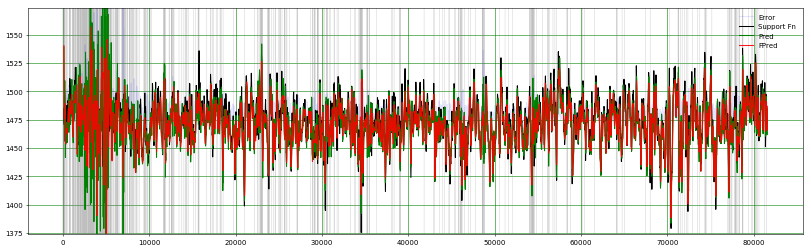

In [28]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import arange, pi
from scipy.signal import savgol_filter

import datetime
import time

%matplotlib inline 


includeTimeElapsed = True




df = pd.read_csv('data/window_Optimal_2h.csv', delimiter=',')

tstamps = np.array(
        [ 
            time.mktime(
                datetime.datetime.strptime( strd, "%Y-%m-%d %H:%M:%S" ).timetuple() 
            ) for strd in df[ 't_stamp' ].values 
        ]
    )

keys = [
    't_stamp', 'Tapp_plus2', 'Tapp', 'Tapp_prev1', 'PCI_3', 'PCI_4',
       'PCI_5', 'HOD_2', 'HOD_3', 'HOD_4', 'COD_2', 'COD_3', 'COD_4', 'SGR610',
       'BFR_1', 'BFR_2', 'CKR610', 'HL_1', 'HL_2', 'HL_3', 'BTemp_2',
       'BTemp_3', 'HODm3', 'PCIm3', 'BMoist_1', 'BMoist_2',
       'Time_Since_Tap_Open'
]

keys = [ 'Tapp', 'Tapp_prev1', 'Time_Since_Tap_Open', 'Tapp_plus2' ]



# keys = [
#     'PCI_3', 'PCI_4',
#        'PCI_5', 'HOD_2', 'HOD_3', 'HOD_4', 'COD_2', 'COD_3', 'COD_4', 'SGR610',
#        'BFR_1', 'BFR_2', 'CKR610', 'HL_1', 'HL_2', 'HL_3', 'BTemp_2',
#        'BTemp_3', 'HODm3', 'PCIm3', 'BMoist_1', 'BMoist_2',
#        'Time_Since_Tap_Open', 'Tapp_plus2'
# ]



# elapsed time between readings (note: the first entry is normally not known)
lags = tstamps[1:]-tstamps[:-1]
lags = np.hstack( (lags[ 0 ], lags ))
lags = lags.reshape( (lags.shape[0], 1) )



# matrix view of the data corresponding to the keys listed above
fn = df.as_matrix( keys )
if includeTimeElapsed == True:
    # ...stack the elapsed timestamps
    fn = np.hstack( (lags, fn) )
# length of a single row (final 'function' should be a sequence of such rows)
singleRowSize = fn.shape[ 1 ]


# if required to filter on some of the columns, e.g. temperature
filterRowsIndx = np.arange( 0, singleRowSize, 1 )
for findx in np.nditer( filterRowsIndx ):
    fn[:, findx] = savgol_filter( fn[:, findx], 11, 5, delta=0.015 )


    
# min and max along each column (note: this DOES include filtered values)
maxfn = np.amax( fn, axis=0 )
minfn = np.amin( fn, axis=0 )

# normalizing function values along each column
fn = (fn - minfn) / (maxfn-minfn)
fn = fn.flatten()



# storing the 'real' values, i.e. not filtered
rfn = df.as_matrix( keys )
if includeTimeElapsed == True:
    # ...stack the elapsed timestamps
    rfn = np.hstack( (lags, rfn) )

# min and max along each column (note: this DOES NOT include filtered values)
maxrfn = np.amax( rfn, axis=0 )
minrfn = np.amin( rfn, axis=0 )

rfn = (rfn - minfn) / (maxfn-minfn)
rfn = rfn.flatten()



# time index (note: not exactly 'correct' as row entries are not homogeneous)
t = np.arange( 0, fn.shape[0], 1 )




# if running in 'adaptive' mode, a sample is used to update the model
# only if the absolute prediction error is above a specified threshold
adaptive = True
errorThreshold = 1.0e-1

# if adaptive mode is 'false' then a percentage of the samples is used
# for training (first percentage * nbSamples, cf. window 'scanner' below)
percentageTraining = 0.5e+0

# response values, actual vs predicted (lresp is for the learnt samples/responses)
resp = []; xresp = []; lresp = [];
# index of the samples that were used as input for learning
lsindx = []


sampleSize = 5
# index and size of the window we will use to scan the data; response offset w.r.t. window
indx = 0; windowSize = sampleSize*singleRowSize-1; respOffset = 1; nbRespValues = 1; maxModelSamples = 3000



# number of hidden units (rough ann simulation)
nbHUnits = windowSize
# initialize a matrix of randow weights (input-hidden layer)
rweights = np.random.randn( windowSize, nbHUnits )
# output weights (that need to be determined, first random)
oweights = np.random.randn( nbHUnits, nbRespValues )



# ann svd for the output layer
annisvd = None



# counters and basic information (time spent training, nb. of samples, etc.)
startt = time.time()

trainingTime = 0
nbTrainingSamples = 0
nbSamples = 0

sampleData = None
sampleDataResponse = None
predTstamp = []



while indx < t.shape[ 0 ] - (windowSize + respOffset-1 + nbRespValues-1 ):
        
    hlinp = np.dot( fn[ indx:windowSize+indx ], rweights )
    hlinp = 1.0/( 1.0 + np.exp( -0.1*hlinp ) ) - 0.5
    
    # store the actual response and calculate the predicted response values
    aresponse = rfn[ indx + (windowSize + respOffset-1) : indx + (windowSize + respOffset-1 + nbRespValues) ]

    presponse = np.dot( hlinp.reshape( 1, nbHUnits ), oweights ).reshape( nbRespValues, )
    
    error = ( np.sum((presponse-aresponse)**2) / nbRespValues )**0.5
    
    xresp = np.append( xresp, presponse[ -1 ] )
    resp  = np.append( resp, aresponse[ -1 ] )

    
    
    if predTstamp is None:
        predTstamp = indx + (windowSize + respOffset-1)
    else:
        predTstamp = np.hstack( (predTstamp, (indx + (windowSize + respOffset-1))) )
    
    
    
    if sampleData is None:
        sampleData = fn[ indx:windowSize+indx ]
        sampleDataResponse = aresponse
    else:
        sampleData = np.vstack( (sampleData, fn[ indx:windowSize+indx ]) )
        sampleDataResponse = np.vstack( (sampleDataResponse, aresponse) )

            
    # no svd has been computed up to now, no prediction can be made
    if annisvd == None:
        X = hlinp.reshape( nbHUnits, 1 )
        U, s, Vt = np.linalg.svd( X, full_matrices=False )
        
        annisvd = iSVD( U, s, Vt, updateVt = True  )        
        lresp = [ aresponse ]
        sampleAdded = True
        
    else:
        
        if (not adaptive and indx < t.shape[ 0 ] * percentageTraining) or (adaptive and error > errorThreshold):
            annisvd.update( hlinp.reshape( nbHUnits, 1 ) )
            lresp = np.vstack( (lresp, aresponse) )                    
            
            if annisvd.Vt.shape[ 1 ] > maxModelSamples:
                annisvd.downdate( 0 )
                lresp = lresp[ 1:, : ]

            
    # updating the output weights - note that the update method adds columns
    # and NOT rows (as it would be expected for Ax = y); the incremental SVD
    # we obtain is thus for A^T - we need however the A^+ (pseudoeinverse of A)
    
    # if A^T = UsV^T (SVD) and knowing that i. (A^T)+ = Vs^{-1}U^T; and (ii) (A^+)^T = (A^T)^+
    # we have that (A^+)^T = Vs^{-1}U^T, following that A^+ = Us^{-1}V^T
    
    # in order to upate the weights, we need to calculate x = A^+ y            
    
    if (not adaptive and indx < t.shape[ 0 ] * percentageTraining) or (adaptive and error > errorThreshold) :

        tstart = time.time()
        nbTrainingSamples = nbTrainingSamples+1

        Ux, sx, Vtx = annisvd.svd()

        nzindx = sx > 0; sx[ nzindx ] = 1.0/sx[ nzindx ]
        oweights = np.dot(
            np.dot( Ux, np.dot( np.diag( sx ), Vtx ) ),
            lresp
        )
        
        tend = time.time()
        trainingTime = trainingTime + (tend-tstart)
        
        lsindx = np.append( lsindx, t[ indx ] )
    
    nbSamples = nbSamples+1
    indx = indx + singleRowSize

endt = time.time()



# scaling back the function to actual temperature values
fn = fn.reshape( (int(fn.shape[ 0 ]/singleRowSize), singleRowSize) )
fn = ( maxfn-minfn )*fn + minfn
fn = fn.flatten()

# rescaling the predicted response w.r.t. the last row entry (normally the prediction column)
xresp = ( maxfn[ singleRowSize-1 ] - minfn[ singleRowSize-1 ] )*xresp + minfn[ singleRowSize-1 ]


# ...and reconstructing the real values
rfn = rfn.reshape( (int(rfn.shape[ 0 ]/singleRowSize), singleRowSize) )
rfn = ( maxrfn-minrfn )*rfn + minrfn
rfn = rfn.flatten()

# rescaling the actual response w.r.t. the last row entry (normally the prediction column)
resp = ( maxrfn[ singleRowSize-1 ] - minrfn[ singleRowSize-1 ] )*resp + minrfn[ singleRowSize-1 ]

print( "Nb of samples:", nbSamples, "(", nbTrainingSamples, "samples used for training )" )
print( "Time:", (endt-startt), "(", trainingTime, "for training )" )
print( "RMSE:", ( np.sum((xresp-resp)**2) / resp.shape[ 0 ] )**0.5 )
print( "FRMSE:", ( np.sum((savgol_filter( xresp, 11, 5, delta=0.015 )-resp)**2) / resp.shape[ 0 ] )**0.5 )

indexes = np.arange( int( xresp.shape[0]*(1-percentageTraining) ), int( xresp.shape[0]*1.0), 1)
print( "TEST RMSE:", ( np.sum((xresp[indexes]-resp[indexes])**2) / resp[indexes].shape[ 0 ] )**0.5 )
print( "TEST FRMSE:", ( np.sum((savgol_filter( xresp[indexes], 11, 5, delta=0.015 )-resp[indexes])**2) / resp[indexes].shape[ 0 ] )**0.5 )



def axvlines(xs, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = plt.gca().get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = plt.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot


fig = plt.figure( 1, figsize = (20, 6), dpi = 50 )
ax1 = fig.add_subplot( 111 )

ax1.grid( True, color = 'green' )
mean = sum( resp )/resp.shape[ 0 ]; delta = 1.0e+2;  ax1.set_ylim( (mean-delta, mean+delta) )

#ax1.set_xlim( (3.500*1e+3, 4.500*1e+3) )

axvlines( lsindx, linewidth=0.5, color='gray', alpha=0.5 )

ax1.plot( predTstamp, mean+np.abs(resp-xresp), 'blue', label = 'Error', alpha = 0.1)
ax1.plot( predTstamp, resp, 'black', label = 'Support Fn') 
ax1.plot( predTstamp, xresp, 'green', label = 'Pred' )
ax1.plot( predTstamp, savgol_filter( xresp, 11, 5, delta=0.015 ), 'red', label = 'FPred', alpha = 0.9 )

ax1.legend(loc='upper right', frameon=False)

plt.show()

Nb of samples: 1629.5
Time: 33.06323599815369 for training
RMSE: 8.619048505580444
FRMSE: 9.805273465818328
TEST RMSE: 11.743519029114053
TEST FRMSE: 11.804411292706924


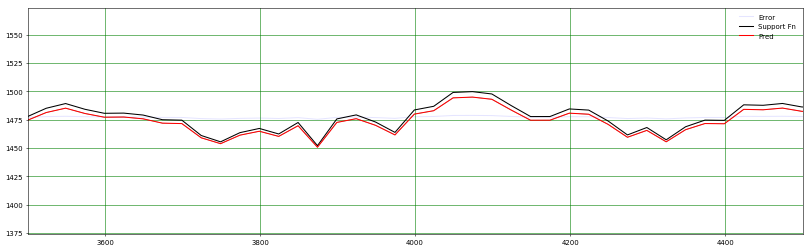

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 100.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           
           1.0 * ExpSineSquared( length_scale=1.0, periodicity=10.0,
                                length_scale_bounds=(0.1, 100.0),
                                periodicity_bounds=(1.0, 1000.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]


gp = GaussianProcessRegressor( kernel = kernels[ 1 ], alpha=1e-10 )


gptstart = time.time()
gp.fit( 
    sampleData[ 0:int(percentageTraining*sampleData.shape[0]), : ], 
    sampleDataResponse[0:int(percentageTraining*sampleData.shape[0])] 
)
gptend = time.time()

gp_response, gp_std = gp.predict( sampleData, return_std=True )
# rescaling the predicted response w.r.t. the last row entry (normally the prediction column)
gp_response = ( maxfn[ singleRowSize-1 ] - minfn[ singleRowSize-1 ] )*gp_response + minfn[ singleRowSize-1 ]


print( "Nb of samples:", percentageTraining*sampleData.shape[0] )
print( "Time:", gptend-gptstart, "for training" )

print( "RMSE:", ( np.sum(( gp_response[ :, -1 ] - resp )**2) / resp.shape[ 0 ] )**0.5 )
print( "FRMSE:", ( np.sum(( savgol_filter( gp_response[ :, -1 ], 11, 5, delta=0.0015 ) - resp )**2) / resp.shape[ 0 ] )**0.5 )

indexes = np.arange( int( resp.shape[0]*(1-percentageTraining) ), int( resp.shape[0]*1.0), 1)
print( "TEST RMSE:", ( np.sum((gp_response[ indexes, -1]-resp[ indexes ])**2) / resp[ indexes ].shape[ 0 ] )**0.5 )
print( "TEST FRMSE:", ( np.sum((savgol_filter( gp_response[ indexes, -1], 11, 5, delta=0.015 )-resp[indexes])**2) / resp[indexes].shape[ 0 ] )**0.5 )



fig = plt.figure( 1, figsize = (20, 6), dpi = 50 )
ax1 = fig.add_subplot( 111 )

ax1.grid( True, color = 'green' )
mean = sum( resp )/resp.shape[ 0 ]; delta = 1.0e+2;  ax1.set_ylim( (mean-delta, mean+delta) )

ax1.set_xlim( (3.500*1e+3, 4.500*1e+3) )

ax1.plot( predTstamp, mean+np.abs(resp-gp_response[:, -1]), 'blue', label = 'Error', alpha = 0.1)

ax1.plot( predTstamp, resp, 'black', label = 'Support Fn' )
ax1.plot( predTstamp, gp_response[ :, nbRespValues-1 ], 'red', label = 'Pred' )


ax1.fill_between( predTstamp, 
                 gp_response[ :, nbRespValues-1 ] - gp_std, 
                 gp_response[ :, nbRespValues-1 ] + gp_std,
                 alpha=0.2, color='k'
                )

ax1.legend(loc='upper right', frameon=False)

plt.show()

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


   0    12.46 16412570.363230826        2 0.12960001076039732 0.13807008632005977      7.90s
   1     5.41 1022848.258059217        1 0.06479518082056436 0.064922598544712     11.72s
   2     4.66 468243.8491889881        1 0.063787478393848 0.06720874913959504     12.03s
   3     3.87 0.3489543036640416        1 0.06413207826175425 0.06643982460946456     12.04s
   4     3.49 0.7448032973394203        1 0.06333709563004218 0.0681945248187619     11.03s
   5     3.03 0.3539979345155062        1 0.06278904542328509 0.06936598537047274      9.99s
   6     2.73 0.351620388024523        1 0.06141670302182856 0.07217350336083417      8.72s
   7     1.83 987341.7203562134        1 0.06078585358570678 0.07340801660620105      7.21s
   8     1.42 104942.6266182343        1 0.060880223281929505 0.07322547373324267      5.70s
   9     1.45 41885.56524482083        1 0.06119922858869595 0.07260289475316803      4.43s
  10     1.48 0.6602549264651784        1 0.061063916250117665 0.072868021035301

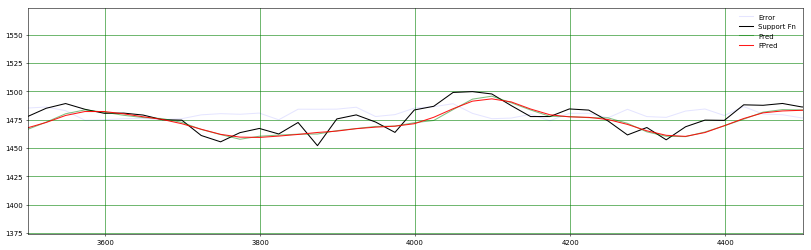

In [21]:
import gplearn as gpl
from gplearn import genetic
from scipy.signal import savgol_filter


def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

        
# function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan', xexp ],

        
xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )

est_gpl = genetic.SymbolicRegressor(population_size=1000,
                           tournament_size=5,
                           function_set=['add', 'sub', 'mul', 'div', 'sin', xexp ],
                           generations=15, stopping_criteria=0.01,
                           p_crossover=0.65, p_subtree_mutation=0.15,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.70, metric = 'rmse', verbose=1,
                           parsimony_coefficient=1e-3, random_state=None )

nbSamples = sampleData.shape[ 0 ]
indx = np.arange( 0, int(nbSamples*percentageTraining), 1 )
est_gpl.fit( sampleData[ indx, : ], sampleDataResponse[ indx, -1 ] )

score_gpl = est_gpl.score( sampleData, sampleDataResponse[:,-1] )
pred_gpl = est_gpl.predict( sampleData )


# rescaling the predicted response w.r.t. the last row entry (normally the prediction column)
pred_gpl = ( maxfn[ singleRowSize-1 ] - minfn[ singleRowSize-1 ] )*pred_gpl + minfn[ singleRowSize-1 ]


print( "RMSE:", ( np.sum((pred_gpl-resp)**2) / pred_gpl.shape[ 0 ] )**0.5 )
print( "FRMSE:", ( np.sum((savgol_filter( pred_gpl, 11, 5, delta=0.015 )-resp)**2) / resp.shape[ 0 ] )**0.5 )

indexes = np.arange( int( resp.shape[0]*(1-percentageTraining) ), int( resp.shape[0]*1.0), 1)
print( "TEST RMSE:", ( np.sum((pred_gpl[ indexes ]-resp[ indexes ])**2) / resp[ indexes ].shape[ 0 ] )**0.5 )
print( "TEST FRMSE:", ( np.sum((savgol_filter( pred_gpl[ indexes ], 11, 5, delta=0.015 )-resp[indexes])**2) / resp[indexes].shape[ 0 ] )**0.5 )


fig = plt.figure( 1, figsize = (20, 6), dpi = 50 )
ax1 = fig.add_subplot( 111 )

ax1.grid( True, color = 'green' )
mean = sum( resp )/resp.shape[ 0 ]; delta = 1.0e+2;  ax1.set_ylim( (mean-delta, mean+delta) )

ax1.set_xlim( (3.500*1e+3, 4.500*1e+3) )

ax1.plot( predTstamp, mean+np.abs(resp-pred_gpl), 'blue', label = 'Error', alpha = 0.1)
ax1.plot( predTstamp, resp, 'black', label = 'Support Fn') 

ax1.plot( predTstamp, pred_gpl, 'green', label = 'Pred', alpha = 0.5 )
ax1.plot( predTstamp, savgol_filter( pred_gpl, 11, 5, delta=0.015 ), 'red', label = 'FPred', alpha = 0.9 )

ax1.legend(loc='upper right', frameon=False)

plt.show()

In [10]:
indexes = np.arange( singleRowSize-1, rfn.shape[ 0 ], singleRowSize )
print( "RMSE:", ( np.sum(( rfn[ indexes[ 1: ] ] - rfn[ indexes[ :-1 ] ] )**2) / (indexes.shape[ 0 ]-1) )**0.5 )
print( "FRMSE:", ( np.sum(( rfn[ indexes[ 1: ] ] - savgol_filter( rfn[ indexes[ :-1 ] ], 11, 5, delta=0.015 ) )**2) / (indexes.shape[ 0 ]-1) )**0.5 )

RMSE: 12.72395661195132
FRMSE: 10.015143356658596
